In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
from IPython.display import Audio
import scipy
from scipy.signal import find_peaks
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.integrate import simps
from scipy.io.wavfile import write
import bisect
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from scipy.fftpack import dct
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, f1_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
import sounddevice as sd
import wavio as wv
from datetime import datetime
import threading
import time
from time import sleep
from statistics import stdev

# Data Preparation

## Data Loading

In [68]:
# Real Cough Timestamps of the Data

def get_real_timestamps(audio_timestamp):

    timestamp = []
    f = open(audio_timestamp, "r")
    content = f.read()
    content = content.split("\n")

    for line in content:
        if line != "":
            timestamp.append(float(line.split("\t")[0]))
    
    return timestamp

In [69]:
# Loading all data
def load_data(audio_file_path, timestamp_file_path, label, sr=48000):
    
    audio_files = [file for file in os.listdir(audio_file_path) if file.endswith('.wav')]
    timestamp_files = [file for file in os.listdir(timestamp_file_path) if file.endswith('.txt')]
    
    
    audios = []
    timestamps = []
    labels = []
    
    for file in audio_files:
    
        file_name = file.split(".wav")[0]    
        timestamp_files = [file[0:19] for file in timestamp_files]    

        # Finding correspoding timestamp file
        index = timestamp_files.index(file_name)
        timestamp_data = timestamp_files[index]

        file_path = audio_file_path + file
        timestamp_path = timestamp_file_path + timestamp_data + '-label.txt'

        # Adding timestamps to the list
        real_timestamps = get_real_timestamps(timestamp_path)    

        # Loading audio_file
        data, sample_rate = librosa.load(file_path, sr=sr)

        audios.append(data)
        timestamps.append(real_timestamps)
        labels.append(label)

    
    return audios, timestamps, labels

In [70]:
audio_data = {'audio': [], 'timestamps': [], 'label': []}
sample_rate = 48000

cough_data, cough_timestamps, cough_labels = load_data('./audio-records/cough/', './audio-records/cough-timestamps/', 'cough')
other_data, other_timestamps, other_labels = load_data('./audio-records/no-cough/', './audio-records/no-cough-timestamps/', 'other')

audio_data['audio'].extend(cough_data)
audio_data['timestamps'].extend(cough_timestamps)
audio_data['label'].extend(cough_labels)

audio_data['audio'].extend(other_data)
audio_data['timestamps'].extend(other_timestamps)
audio_data['label'].extend(other_labels)

## Data Splitting

In [71]:
df_init = pd.DataFrame.from_dict(audio_data)

X_init = df_init.iloc[:, :-1]
y_init = df_init.iloc[:, -1]

X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X_init, y_init, random_state= 3, train_size=0.80)

## Data Normalization and Filtering

### Preprocessing Functions

In [72]:
# Data Normalization

def normalize_data(data):
    min = np.min(data)
    max = np.max(data)

    data = (data - min) / (max - min)
    return data

In [73]:
# Moving Average of the Data:
def compute_moving_average(data, window_size=15):
    
    kernel = np.ones(window_size) / window_size
    moving_averages = np.convolve(data, kernel, mode='valid')
    moving_averages = np.round(moving_averages, 2)
    
    return np.array(moving_averages)

In [74]:
# Filtering of the data

def butter_bandpass(lowcut, highcut, fs, order=8):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=8):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [75]:
# Preprocessing 
def preprocess_data(data):
    
    # Filtering data
    data = butter_bandpass_filter(data, 1000, 4000, sample_rate,8)

    # Getting moving average of the data
    data = compute_moving_average(np.abs(data))

    # Scaling data
    data = data.reshape(-1,1)    
    scaler = preprocessing.StandardScaler().fit(data)
    data = scaler.transform(data)
    
    # Normalize data
    data = normalize_data(data)
    data = data.flatten()
    
    return data   

### Percentile Calculation Functions

In [76]:
def binary_search(auc_values, threshold):
    index = bisect.bisect_left(auc_values, threshold)
    if index < len(auc_values):
        return index
    return None

In [77]:
# Percentile Points of a Signal

def find_percentile_points(signal):
    
        # Calculating Fast Fourier Transform
        X = np.fft.fft(signal)
        X_mag = np.abs(X) / len(signal)
        freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)

        # Graph
        positive_freq_indices = np.where(freqs >= 0)

        # Getting positive part
        freqs = freqs[positive_freq_indices]
        X_mag = X_mag[positive_freq_indices]
    
        auc = simps(X_mag, freqs)

        per_25 = auc * 0.25
        per_50 = auc * 0.50
        per_75 = auc * 0.75
        per_90 = auc * 0.90

        # Cumulative area
        cumulative_auc = [simps(X_mag[:i+1], freqs[:i+1]) for i in range(len(freqs))]

        # Find the indices for each percentile
        point_1 = binary_search(cumulative_auc, per_25)
        point_2 = binary_search(cumulative_auc, per_50)
        point_3 = binary_search(cumulative_auc, per_75)
        point_4 = binary_search(cumulative_auc, per_90)

        per_25_result = freqs[point_1]
        per_50_result = freqs[point_2]
        per_75_result = freqs[point_3]
        per_90_result = freqs[point_4]
        
        return per_25_result, per_50_result, per_75_result, per_90_result

### MFCC Calculation Functions

In [78]:
# MFCC values of a Signal

def get_mfcc_features(signal):
        
    # Original MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate)
    
    # First derivative of MFCCs
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Second derivative of MFCCs
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    return mfccs, delta_mfccs, delta2_mfccs

### Extracting Data Features

In [79]:
timestamp_range_min = 0.1
timestamp_range_max = 0.2
data_shape = int((timestamp_range_min + timestamp_range_max) * sample_rate)

Audiodata_train = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'mfcc': [], 'sc':[], 'label': []}

for (info, label) in zip(X_train_init.values, y_train_init.values):

    data = info[0]
    timestamps = info[1]

    data = preprocess_data(data)
    
    # Extracting coughs/others
    for timestamp in timestamps:

        start = int((timestamp - timestamp_range_min) * sample_rate)
        finish = int((timestamp + timestamp_range_max) * sample_rate)

        if start < 0:
            start = 0

        if finish > len(data):
            finish = len(data) - 1

        extracted_data = data[start:finish]
        
        if (len(extracted_data) != data_shape):
            continue
                            
        # Find percentile points
        per_25, per_50, per_75, per_90 = find_percentile_points(extracted_data)

        # MFCC Feature extraction
        mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(extracted_data)

        # Comprehensive MFCCs  
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

        # Find spectral centroids
        sc = librosa.feature.spectral_centroid(y=extracted_data, sr=sample_rate)

        Audiodata_train['percentile_25'].append(per_25)
        Audiodata_train['percentile_50'].append(per_50)
        Audiodata_train['percentile_75'].append(per_75)
        Audiodata_train['percentile_90'].append(per_90)
        Audiodata_train['mfcc'].append(comprehensive_mfccs)            
        Audiodata_train['sc'].append(sc)
        Audiodata_train['label'].append(label)

In [80]:
timestamp_range_min = 0.1
timestamp_range_max = 0.2
data_shape = int((timestamp_range_min + timestamp_range_max) * sample_rate)

Audiodata_test = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'mfcc': [], 'sc':[], 'label': []}

for (info, label) in zip(X_test_init.values, y_test_init.values):

    data = info[0]
    timestamps = info[1]
    
    # Filtering data
    data = preprocess_data(data)
    
    # Extracting coughs/others
    for timestamp in timestamps:

        start = int((timestamp - timestamp_range_min) * sample_rate)
        finish = int((timestamp + timestamp_range_max) * sample_rate)

        if start < 0:
            start = 0

        if finish > len(data):
            finish = len(data) - 1

        extracted_data = data[start:finish]
        
        if (len(extracted_data) != data_shape):
            continue
                            
        # Find percentile points
        per_25, per_50, per_75, per_90 = find_percentile_points(extracted_data)

        # MFCC Feature extraction
        mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(extracted_data)

        # Comprehensive MFCCs  
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

        # Find spectral centroids
        sc = librosa.feature.spectral_centroid(y=extracted_data, sr=sample_rate)

        Audiodata_test['percentile_25'].append(per_25)
        Audiodata_test['percentile_50'].append(per_50)
        Audiodata_test['percentile_75'].append(per_75)
        Audiodata_test['percentile_90'].append(per_90)
        Audiodata_test['mfcc'].append(comprehensive_mfccs)            
        Audiodata_test['sc'].append(sc)
        Audiodata_test['label'].append(label)

## Train and Test Data

In [81]:
# Converting the Audiodata dictionary into the pandas dataframe

# Train data

df_train = pd.DataFrame.from_dict(Audiodata_train)

print("Train Data \n")
print("-------------------")
print(df_train.head())
print()

mfcc_values = np.array(df_train['mfcc'].tolist())
mfcc_values = mfcc_values.reshape(mfcc_values.shape[0], -1)

sc_values = np.array(df_train['sc'].tolist())
sc_values = sc_values.reshape(sc_values.shape[0], -1)

percentile_values = df_train.iloc[:, :4].values

X_train = np.concatenate((percentile_values, mfcc_values, sc_values), axis=1)
X_train_per = percentile_values
X_train_per_mfcc =  np.concatenate((percentile_values, mfcc_values), axis=1)
X_train_mfcc_sc = np.concatenate((mfcc_values, sc_values), axis=1)

label_encoder = LabelEncoder()
y_train = df_train.iloc[:, -1]
y_train = 1 - label_encoder.fit_transform(y_train)

# Test data (Data for Final Evaluation)

df_test = pd.DataFrame.from_dict(Audiodata_test)

print("Test Data \n")
print("-------------------")
print(df_test.head())
print()

mfcc_values = np.array(df_test['mfcc'].tolist())
mfcc_values = mfcc_values.reshape(mfcc_values.shape[0], -1)

sc_values = np.array(df_test['sc'].tolist())
sc_values = sc_values.reshape(sc_values.shape[0], -1)

percentile_values = df_test.iloc[:, :4].values

X_test = np.concatenate((percentile_values, mfcc_values, sc_values), axis=1)
X_test_per_mfcc = np.concatenate((percentile_values, mfcc_values), axis=1)

y_test = df_test.iloc[:, -1]
y_test = 1 - label_encoder.fit_transform(y_test)

Train Data 

-------------------
   percentile_25  percentile_50  percentile_75  percentile_90  \
0     513.333333    2366.666667    8483.333333   16733.333333   
1      83.333333     363.333333    2200.000000    7653.333333   
2     470.000000    1690.000000    7510.000000   16290.000000   
3     356.666667    1730.000000    7173.333333   15620.000000   
4     516.666667    1830.000000    7336.666667   16150.000000   

                                                mfcc  \
0  [[-853.1245436132787, -853.1245436132787, -853...   
1  [[-570.3859507988184, -570.3859507988184, -570...   
2  [[-656.9144670612467, -656.9144670612467, -656...   
3  [[-210.86619898322542, -199.2732995213591, -28...   
4  [[-149.6151721267201, -115.91101280957079, -10...   

                                                  sc  label  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5349...  other  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3058.3091...  other  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4661.763563236... 

In [82]:
kf = KFold(n_splits=5, shuffle=False)

## KNN Model Performance Testing

Best Parameters: {'n_neighbors': 3, 'weights': 'uniform'}
F1 Score: 0.78


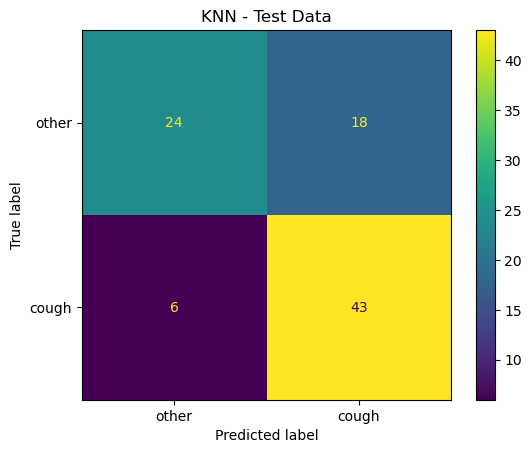

Before Hyperparameter Tuning
-----------------------------------------------------
Cross Validation F1 scores are: [0.71428571 0.73076923 0.71052632 0.85       0.79545455]
Average Cross Validation F1 score:  0.7602071612597928

Cross Validation Recall scores are: [0.96153846 1.         0.5625     0.94444444 0.83333333]
Average Cross Validation Recall score:  0.8603632478632479

After Hyperparameter Tuning
-----------------------------------------------------
Cross Validation F1 scores are: [0.72463768 0.71698113 0.7804878  0.84337349 0.82758621]
Average Cross Validation F1 score:  0.7786132637970791

Cross Validation Recall scores are: [0.96153846 1.         0.66666667 0.97222222 0.85714286]
Average Cross Validation Recall score:  0.8915140415140416


In [101]:
# Train the model using the training set
clf_knn = KNeighborsClassifier(p=2)

# Before Hyperparameter Tuning - Cross Validation Scores
score_f1 = cross_val_score(clf_knn, X_train, y_train, cv=kf, scoring='f1')
score_rc = cross_val_score(clf_knn, X_train, y_train, cv=kf, scoring='recall')
cv_score_f1 = score_f1.mean()
cv_score_rc = score_rc.mean()

# Hyperparameter tuning based on the validation performance
param_grid_knn = [
    {
    'n_neighbors': list(range(3, int(len(X_train) * 0.65),2)),
    'weights': ['uniform', 'distance']
    },
]

# GridSearchCV
optimal_params_knn = GridSearchCV(estimator=clf_knn,
                                  param_grid=param_grid_knn,
                                  cv=5,
                                  scoring='f1'
                                )

optimal_params_knn.fit(X_train, y_train)
best_params = optimal_params_knn.best_params_

print("Best Parameters: {}".format(best_params))
clf_knn = KNeighborsClassifier(**best_params)
clf_knn.fit(X_train, y_train)


# After Hyperparameter Tuning - Cross Validation Scores
score_f1_optimized = cross_val_score(clf_knn, X_train, y_train, cv=kf, scoring='f1')
score_rc_optimized = cross_val_score(clf_knn, X_train, y_train, cv=kf, scoring='recall')
cv_score_rc_optimized = score_rc_optimized.mean()
cv_score_f1_optimized = score_f1_optimized.mean()


# Prediction on Test Data
y_pred = clf_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("F1 Score: {}".format(round(f1,2)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['other', 'cough'])
disp.plot()
plt.title("KNN - Test Data")
plt.show()

print("Before Hyperparameter Tuning")
print("-----------------------------------------------------")
print('Cross Validation F1 scores are: {}'.format(score_f1))
print('Average Cross Validation F1 score: ', cv_score_f1)
print('\nCross Validation Recall scores are: {}'.format(score_rc))
print('Average Cross Validation Recall score: ', cv_score_rc)

print("\nAfter Hyperparameter Tuning")
print("-----------------------------------------------------")
print('Cross Validation F1 scores are: {}'.format(score_f1_optimized))
print('Average Cross Validation F1 score: ', cv_score_f1_optimized)
print('\nCross Validation Recall scores are: {}'.format(score_rc_optimized))
print('Average Cross Validation Recall score: ', cv_score_rc_optimized)

## SVM Model Performance Testing


Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
F1 Score: 0.85


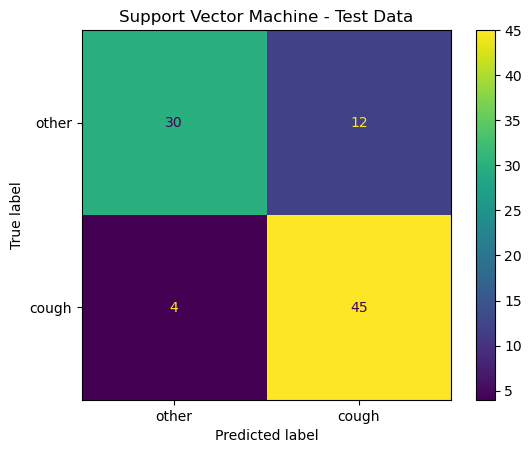

Before Hyperparameter Tuning
-----------------------------------------------------
Cross Validation F1 scores are: [0.74626866 0.71698113 0.7027027  0.8        0.7816092 ]
Average Cross Validation F1 score:  0.7495123373793782

Cross Validation Recall scores are: [0.96153846 1.         0.54166667 0.88888889 0.80952381]
Average Cross Validation Recall score:  0.8403235653235652

After Hyperparameter Tuning
-----------------------------------------------------
Cross Validation F1 scores are: [0.72727273 0.84444444 0.75       0.83544304 0.8       ]
Average Cross Validation F1 score:  0.791432041938371

Cross Validation Recall scores are: [0.92307692 1.         0.625      0.91666667 0.80952381]
Average Cross Validation Recall score:  0.8548534798534799


In [102]:
# Support Vector Machine

# Optimize the parameters
# Finding the best value for gamma and regularization parameter

# C: regularization parameter

# Before Hyperparameter Tuning - Cross Validation Scores
clf_svm_init = SVC()

score_f1 = cross_val_score(clf_svm_init, X_train, y_train, cv=kf, scoring='f1')
score_rc = cross_val_score(clf_svm_init, X_train, y_train, cv=kf, scoring='recall')
cv_score_f1 = score_f1.mean()
cv_score_rc = score_rc.mean()

param_grid = [
    {
    'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
    },
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='f1'
)

optimal_params.fit(X_train, y_train)
C = optimal_params.best_params_['C']
gamma = optimal_params.best_params_['gamma']


# Model Training and Prediction
clf_svm = SVC(random_state=42, C=C, gamma=gamma)
clf_svm.fit(X_train, y_train)

# After Hyperparameter Tuning - Cross Validation Scores
score_f1_optimized = cross_val_score(clf_svm, X_train, y_train, cv=kf, scoring='f1')
score_rc_optimized = cross_val_score(clf_svm, X_train, y_train, cv=kf, scoring='recall')
cv_score_f1_optimized = score_f1_optimized.mean()
cv_score_rc_optimized = score_rc_optimized.mean()


# Prediction on Test Data
y_pred = clf_svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nBest Parameters: {}".format(optimal_params.best_params_))
print("F1 Score: {}".format(round(f1,2)))

display_labels = ['Other', 'Cough']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['other', 'cough'])
disp.plot()
plt.title("Support Vector Machine - Test Data")
plt.show()


print("Before Hyperparameter Tuning")
print("-----------------------------------------------------")
print('Cross Validation F1 scores are: {}'.format(score_f1))
print('Average Cross Validation F1 score: ', cv_score_f1)
print('\nCross Validation Recall scores are: {}'.format(score_rc))
print('Average Cross Validation Recall score: ', cv_score_rc)

print("\nAfter Hyperparameter Tuning")
print("-----------------------------------------------------")
print('Cross Validation F1 scores are: {}'.format(score_f1_optimized))
print('Average Cross Validation F1 score: ', cv_score_f1_optimized)
print('\nCross Validation Recall scores are: {}'.format(score_rc_optimized))
print('Average Cross Validation Recall score: ', cv_score_rc_optimized)

## Model Comparisons

### With Default Hyperparameters

In [103]:
# Comparing the models with default hyperparameter values using Cross Validation

# List of models
models = [LogisticRegression(max_iter=3000), SVC(kernel='linear'), KNeighborsClassifier(), RandomForestClassifier(random_state=0), GaussianNB()]

In [104]:
def compare_models_cross_validation():
   
    for model in models:
        
        cross_val_accuracies = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
        mean_accuracy = np.mean(cross_val_accuracies)
        
        print('\033[1m' + str(model) + '\033[0m') 
        print("--------------------------------------------")
        print()
        
        print("All - Cross Validation Accuracies: " + str(cross_val_accuracies))
        print("F1 Score: {}".format(round(mean_accuracy, 2)))
        
        print()
        
        cross_val_accuracies = cross_val_score(model, X_train_per, y_train, cv=5, scoring='f1')
        mean_accuracy = np.mean(cross_val_accuracies)
        
        print("Percentiles - Cross Validation Accuracies: " + str(cross_val_accuracies))
        print("F1 Score: {}".format(round(mean_accuracy, 2)))
        
        print()

        cross_val_accuracies = cross_val_score(model, X_train_per_mfcc, y_train, cv=5, scoring='f1')
        mean_accuracy = np.mean(cross_val_accuracies)
        
        print("Percentiles and MFCCs - Cross Validation Accuracies: " + str(cross_val_accuracies))
        print("F1 Score: {}".format(round(mean_accuracy, 2)))

        print()

        cross_val_accuracies = cross_val_score(model, X_train_mfcc_sc, y_train, cv=5, scoring='f1')
        mean_accuracy = np.mean(cross_val_accuracies)
        
        print("MFCCs and Spectral Centroids - Cross Validation Accuracies: " + str(cross_val_accuracies))
        print("F1 Score: {}".format(round(mean_accuracy, 2)))
                
        print()

In [105]:
compare_models_cross_validation()

/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

LogisticRegression(max_iter=3000)
--------------------------------------------

All - Cross Validation Accuracies: [0.83783784 0.71604938 0.86153846 0.75949367 0.75      ]
F1 Score: 0.78

Percentiles - Cross Validation Accuracies: [0.8        0.64102564 0.77419355 0.68571429 0.57142857]
F1 Score: 0.69



/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Percentiles and MFCCs - Cross Validation Accuracies: [0.88888889 0.8        0.83076923 0.78481013 0.74666667]
F1 Score: 0.81



/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

MFCCs and Spectral Centroids - Cross Validation Accuracies: [0.84931507 0.71428571 0.72413793 0.70731707 0.74285714]
F1 Score: 0.75

SVC(kernel='linear')
--------------------------------------------

All - Cross Validation Accuracies: [0.84931507 0.775      0.86153846 0.75675676 0.7826087 ]
F1 Score: 0.81

Percentiles - Cross Validation Accuracies: [0.86111111 0.65060241 0.8125     0.74666667 0.61971831]
F1 Score: 0.74

Percentiles and MFCCs - Cross Validation Accuracies: [0.84210526 0.78481013 0.85714286 0.80519481 0.77333333]
F1 Score: 0.81

MFCCs and Spectral Centroids - Cross Validation Accuracies: [0.86111111 0.72222222 0.78688525 0.7        0.7826087 ]
F1 Score: 0.77

KNeighborsClassifier()
--------------------------------------------

All - Cross Validation Accuracies: [0.825      0.75       0.85294118 0.82051282 0.75675676]
F1 Score: 0.8

Percentiles - Cross Validation Accuracies: [0.79012346 0.74074074 0.78125    0.7027027  0.7       ]
F1 Score: 0.74

Percentiles and MFCCs - C

### With Different Hyperparameters

In [88]:
models_list = [LogisticRegression(max_iter=3000), SVC(), KNeighborsClassifier(), RandomForestClassifier(random_state=0), GaussianNB()]

In [89]:
model_hyperparameters = {
    
    'log_reg_hyperparameters': {
        
        'C': [1, 5, 10, 20]
        
    },
    
    'svc_hyperparameters': {
        
        'C': [0.5, 1, 10, 100],
        'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
        
    },
    
    'KNN_hyperparameters': {
        
        'n_neighbors': list(range(3, int(len(X_train) * 0.65),2)),
        'weights': ['uniform', 'distance']

    },
    
    'random_forest_hyperparameters': {
        
        'n_estimators': [10, 20, 50, 100]
    },
    
    'naive_bayes_hyperparameters': {
    
        'var_smoothing': np.logspace(0,-9, num=100)
    },
        
}

moodel_keys = list(model_hyperparameters.keys())

In [90]:
def model_selection(list_of_models, hyperparameter_dict):
    
    results = []

    for i in range(len(list_of_models)):
        
        key = moodel_keys[i]
        params = hyperparameter_dict[key]
        
        classifier = GridSearchCV(list_of_models[i], params, cv=5, scoring='f1')
        classifier.fit(X_train, y_train)
        
        results.append({
            'model used': list_of_models[i],
            'highest score': classifier.best_score_,
            'best hyperparameters': classifier.best_params_,
            
        })

    
    result_dataframe = pd.DataFrame(results, columns = ['model used', 'highest score', 'best hyperparameters'])    
    return result_dataframe

In [91]:
result_df = model_selection(models_list, model_hyperparameters)

result_df

/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

,model used,highest score,best hyperparameters
0,LogisticRegression(max_iter=3000),0.784984,{'C': 1}
1,SVC(),0.811902,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}"
2,KNeighborsClassifier(),0.816799,"{'n_neighbors': 3, 'weights': 'uniform'}"
3,RandomForestClassifier(random_state=0),0.872975,{'n_estimators': 50}
4,GaussianNB(),0.864830,{'var_smoothing': 1e-08}


## Test Performance Scores of Each Model


LogisticRegression(C=1, max_iter=3000)
--------------------------------------------
Confusion Matrix: 
 [[29 13]
 [ 8 41]]

F1 Score: 0.7961165048543689
Recall Score: 0.8367346938775511



/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


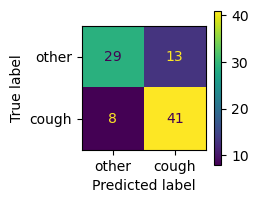


SVC(C=100)
--------------------------------------------
Confusion Matrix: 
 [[30 12]
 [ 4 45]]

F1 Score: 0.8490566037735849
Recall Score: 0.9183673469387755



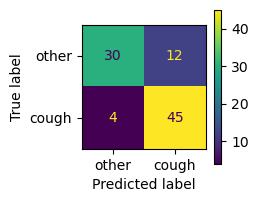


KNeighborsClassifier(n_neighbors=3)
--------------------------------------------
Confusion Matrix: 
 [[24 18]
 [ 6 43]]

F1 Score: 0.7818181818181819
Recall Score: 0.8775510204081632



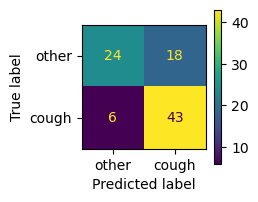


RandomForestClassifier(n_estimators=50, random_state=0)
--------------------------------------------
Confusion Matrix: 
 [[32 10]
 [ 5 44]]

F1 Score: 0.8543689320388349
Recall Score: 0.8979591836734694



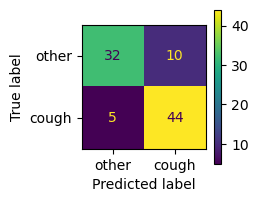


GaussianNB(var_smoothing=1e-08)
--------------------------------------------
Confusion Matrix: 
 [[37  5]
 [ 4 45]]

F1 Score: 0.9090909090909091
Recall Score: 0.9183673469387755



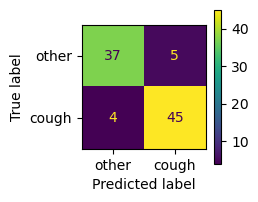

In [100]:
for model_info in result_df.values:
    
    model = model_info[0]
    best_params = model_info[2]
    
    model.set_params(**best_params)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print()
    print('\033[1m' + str(model) + '\033[0m') 
    print("--------------------------------------------")
    print("Confusion Matrix: \n {}".format(cm))
    print("\nF1 Score: {}".format(f1))
    print("Recall Score: {}\n".format(recall))
    
    display_labels = ['Other', 'Cough']
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['other', 'cough'])
    fig = disp.figure_
    fig.set_figwidth(2)
    fig.set_figheight(2) 
    plt.show()

# Prediction of Cough Count with Extraction and Classification - New Separata Data

## Time Domain Sound Extraction Functions

In [93]:
# Cough Detection Algorithm

def detect_coughs_time_domain(data):
    
    max_value = np.max(data)
    mean_value = np.mean(data)
    std = np.std(data)

    # Threshold 
    percentile_threshold = 90
    threshold = np.percentile(data, percentile_threshold)

    # Peak detection
    cough_indices, _ = find_peaks(data, prominence = 0.3)
    cough_indices = list(cough_indices)

    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 5000, peak + 5000) # The range is determined experimentally

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]

        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (data[index] > data[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1


    # Applying the threshold
    cough_indices_copy = cough_indices.copy()
    for index in cough_indices_copy:

        amplitude = data[index]

        if (amplitude < threshold):
            cough_indices.remove(index)


    # Finding the timestamps of the coughs
    predicted_timestamps = []
    for index in cough_indices:
        predicted_timestamps.append(round(index / sample_rate, 6))


    # Filtering the sound after coughing
    for ts in predicted_timestamps:
        matches = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.4))

        if len(matches) != 0:
            for i in range(len(matches)):
                index = predicted_timestamps.index(matches[i])
                predicted_timestamps.remove(matches[i])
                cough_indices.remove(cough_indices[index])

    return cough_indices, predicted_timestamps

## Frequency Domain Sound Extraction Functions

In [94]:
# Summation of the frequency bins in a spectogram

def get_frequency_sums(mel_spectrogram_db):
    
    sums = []
    S_db_tp = np.transpose(mel_spectrogram_db)

    for bin in S_db_tp:
        sums.append(np.sum(bin))

    sums = np.array(sums)

    return sums

In [95]:
def detect_coughs_freq_domain(data, percentile_threshold = 90):
    
    duration = len(data) / sample_rate
    
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate)
    mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)    
    
    frequency_sums = get_frequency_sums(mel_spectrogram_db)
    
    # Threshold 
    threshold = np.percentile(frequency_sums, percentile_threshold)
    
    # Peak detection
    cough_indices, _ = find_peaks(frequency_sums, prominence = 0.3)
    cough_indices = list(cough_indices)
    
    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 50, peak + 50) # The range is determined experimentally

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]

        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (frequency_sums[index] > frequency_sums[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1

    # Applying the threshold
    cough_indices_copy = list(cough_indices)
    for index in cough_indices_copy: 
        amplitude = frequency_sums[index]
        if amplitude < threshold:
            cough_indices.remove(index)
    
    # Finding the timestamps of the coughs
    predicted_timestamps = []
    
    total_samples = len(data)
    data_length = len(frequency_sums)
    
    # Finding the timestamps of the coughs
    for index in cough_indices:
        
        actual_index = total_samples * index / data_length
        actual_timestamp = round(actual_index / sample_rate, 6)
        
        predicted_timestamps.append(actual_timestamp)
    
    # Filtering the sound after coughing
    for ts in predicted_timestamps:
        match = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.4))
        if len(match) != 0:
            index = predicted_timestamps.index(match[0])
            predicted_timestamps.remove(match[0])
            cough_indices.remove(cough_indices[index])

    
    return cough_indices, predicted_timestamps

In [96]:
def detect_coughs(preprocessed_data, model):

    # Extraction of high frequency signals (cough/other) from the audio
    audio_peak_extractions = []
    
    # Time-based and frequency-based extractions
    cough_indices_time, predicted_timestamps_time = detect_coughs_time_domain(preprocessed_data)
    cough_indices_freq, predicted_timestamps_freq = detect_coughs_freq_domain(preprocessed_data)

    predicted_timestamps = []

    # Getting predicted timestamps by comparing time-based and frequency-based extractions
    for timestamp in predicted_timestamps_freq:

        if any(timestamp - 0.15 < element < timestamp + 0.15 for element in predicted_timestamps_time):

            predicted_timestamps.append(timestamp)
    
    # Getting the extracted data
    for timestamp in predicted_timestamps:

        start = int((timestamp - timestamp_range_min) * sample_rate)
        finish = int((timestamp + timestamp_range_max) * sample_rate)

        if start < 0:
            start = 0

        if finish > len(preprocessed_data):
            finish = len(preprocessed_data) - 1

        extracted_data = preprocessed_data[start:finish]
    
        # Add padding or truncate if necessary
        if len(extracted_data) < data_shape:

            padding_size = data_shape - len(extracted_data)
            left_padding = padding_size // 2
            right_padding = padding_size - left_padding

            extracted_data = np.pad(extracted_data, (left_padding, right_padding), mode='constant', constant_values=0)

        elif len(extracted_data) > data_shape:
            extracted_data = extracted_data[:data_shape]

        audio_peak_extractions.append((extracted_data, timestamp))
    
    # Getting features of the extracted audio data
    Audiodata_new = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'mfcc': [], 'sc':[]}
    
    for peak, timestamp in audio_peak_extractions:

        # Percentile Calculation
        per_25, per_50, per_75, per_90 = find_percentile_points(peak)


        # MFCC Feature extraction
        mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(peak)

        # Comprehensive MFCCs
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

        # Find spectral centroids
        sc = librosa.feature.spectral_centroid(y=peak, sr=sample_rate)

        Audiodata_new['percentile_25'].append(per_25)
        Audiodata_new['percentile_50'].append(per_50)
        Audiodata_new['percentile_75'].append(per_75)
        Audiodata_new['percentile_90'].append(per_90)
        Audiodata_new['mfcc'].append(comprehensive_mfccs)
        Audiodata_new['sc'].append(sc)


    df_new = pd.DataFrame.from_dict(Audiodata_new)

    # Both MFCCs and Percentiles
    mfcc_values = np.array(df_new['mfcc'].tolist())
    mfcc_values = mfcc_values.reshape(mfcc_values.shape[0], -1)

    sc_values = np.array(df_new['sc'].tolist())
    sc_values = sc_values.reshape(sc_values.shape[0], -1)

    percentile_values = df_new.iloc[:, :4].values

    new_data = np.concatenate((percentile_values, mfcc_values, sc_values), axis=1)    
    prediction = model.predict(new_data)
    
    final_prediction = []
    
    for i in range(len(predicted_timestamps)):
        if (prediction[i] == 1):
            final_prediction.append(predicted_timestamps[i])

    return final_prediction

# Prediction and Performance

In [97]:
# Test data loading

audio_data_test = {'audio': [], 'timestamps': []}

sample_rate = 48000

test_data, test_timestamps, _ = load_data('./audio-records/test/', './audio-records/test-timestamps/', 'test')

audio_data_test['audio'].extend(test_data)
audio_data_test['timestamps'].extend(test_timestamps)

new_test_df = pd.DataFrame.from_dict(audio_data_test)
new_test_df

,audio,timestamps


In [98]:
"""
Models: 

0              LogisticRegression(C=20, max_iter=3000)
1                                           SVC(C=0.5)
2    KNeighborsClassifier(n_neighbors=161, weights=...
3    (DecisionTreeClassifier(max_features='sqrt', r...
4      GaussianNB(var_smoothing=5.336699231206313e-07)

"""

model_list = result_df['model used']

In [99]:
predicted_and_real_timestamps = {'real': [], 'predicted': []}

# Statistics about predicted timestamps

for model in model_list: 
    
    tp = 0
    fp = 0
    fn = 0

    for row in new_test_df.values:

        data = row[0]
        timestamps = row[1]

        data = preprocess_data(data)

        detected_cough_timestamps = detect_coughs(data, model)

        predicted_and_real_timestamps['real'].append(timestamps)
        predicted_and_real_timestamps['predicted'].append(detected_cough_timestamps)

    pr_df = pd.DataFrame.from_dict(predicted_and_real_timestamps)

    for row in pr_df.values:

        real_timestamps = row[0]
        predicted_timestamps = row[1]

        real_timestamps.sort()
        predicted_timestamps.sort()

        for real, pred in zip(real_timestamps, predicted_timestamps):
            if any(real - 0.15 < p < real + 0.15 for p in predicted_timestamps):
                tp += 1
            else:
                fn += 1

            if not any(pred - 0.15 < r < pred + 0.15 for r in real_timestamps):
                fp += 1

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * recall * precision / (recall + precision)

    print(f"The F1 score of {model}: {f1}")
    print()

ZeroDivisionError: division by zero

## Cough Data Statistics

In [ ]:
cough_data = df_train[df_train['label'] == 'cough']
per_25_data = cough_data['percentile_25']
per_50_data = cough_data['percentile_50']
per_75_data = cough_data['percentile_75']
per_90_data = cough_data['percentile_90']


mfccs_cough = cough_data['mfcc']

cough_mfcc_max = []
cough_mfcc_min = []
cough_mfcc_mean = []
cough_mfcc_std = []

for mfcc in mfccs_cough:
    
    cough_mfcc_max.append(np.max(mfcc))
    cough_mfcc_min.append(np.min(mfcc))
    cough_mfcc_mean.append(np.mean(mfcc))
    cough_mfcc_std.append(np.std(mfcc))

scs_cough = cough_data['sc']
cough_sc_max = []
cough_sc_min = []
cough_sc_mean = []
cough_sc_std = []

for sc in scs_cough:
    
    cough_sc_max.append(np.max(sc))
    cough_sc_min.append(np.min(sc))
    cough_sc_mean.append(np.mean(sc))
    cough_sc_std.append(np.std(sc))

## Other Data Statistics

In [ ]:
other_data = df_train[df_train['label'] == 'other']

no_cough_per_25_data = other_data['percentile_25']
no_cough_per_50_data = other_data['percentile_50']
no_cough_per_75_data = other_data['percentile_75']
no_cough_per_90_data = other_data['percentile_90']

mfccs_other = other_data['mfcc']

other_mfcc_max = []
other_mfcc_min = []
other_mfcc_mean = []
other_mfcc_std = []

for mfcc in mfccs_other:
    
    other_mfcc_max.append(np.max(mfcc))
    other_mfcc_min.append(np.min(mfcc))
    other_mfcc_mean.append(np.mean(mfcc))
    other_mfcc_std.append(np.std(mfcc))
 
scs_other = other_data['sc']
other_sc_max = []
other_sc_min = []
other_sc_mean = []
other_sc_std = []

for sc in scs_other:
    
    other_sc_max.append(np.max(sc))
    other_sc_min.append(np.min(sc))
    other_sc_mean.append(np.mean(sc))
    other_sc_std.append(np.std(sc))

In [ ]:
# 4 Dimensional Graph
# Combinations

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

img_1 = ax.scatter(no_cough_per_25_data, no_cough_per_50_data, no_cough_per_75_data, c= no_cough_per_90_data, cmap='viridis')
colorbar_1 = fig.colorbar(img_1, ax=[ax], shrink=0.3)
colorbar_1.set_label('Other - 90th Percentile')


img_2 = ax.scatter(per_25_data, per_50_data, per_75_data, c= per_90_data, cmap=plt.hot())
colorbar_2 = fig.colorbar(img_2, ax=[ax], shrink=0.3, pad=0.20)

ax.set_xlabel('25th Percentile')
ax.set_ylabel('50th Percentile')
ax.set_zlabel('75th Percentile')
colorbar_2.set_label('Cough - 90th Percentile')

plt.title("Percentiles")
plt.show()




# MFCC Mean Values
# Cough
i = 0
for point in cough_mfcc_mean:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point in other_mfcc_mean:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("MFCC Mean")
plt.xlabel("MFCC")
plt.legend()
plt.ylim(0, 4)
plt.show()




# Sprectral Centroid Mean Values
i = 0
for point in cough_sc_mean:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point in other_sc_mean:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("Spectral Centroid Mean")
plt.xlabel("SC")
plt.legend()
plt.ylim(0, 4)
plt.show()



# MFCC and SC 2D Graph

# Cough
i = 0
for point1, point2 in zip(cough_mfcc_mean, cough_sc_mean):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(other_mfcc_mean, other_sc_mean):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("MFCC x Spectral Centroid Mean")
plt.xlabel("MFCC")
plt.ylabel("Spectral Centroid")
plt.legend()
plt.show()



# MFCC and SC 2D Graph

# Cough
i = 0
for point1, point2 in zip(cough_mfcc_max, cough_sc_max):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(other_mfcc_max, other_sc_max):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("MFCC x Spectral Centroid Max")
plt.xlabel("MFCC")
plt.ylabel("Spectral Centroid")
plt.legend()
plt.show()


# MFCC and SC 2D Graph

# Cough
i = 0
for point1, point2 in zip(cough_mfcc_min, cough_sc_min):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(other_mfcc_min, other_sc_min):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("MFCC x Spectral Centroid Min")
plt.xlabel("MFCC")
plt.ylabel("Spectral Centroid")
plt.legend()
plt.show()


# MFCC and SC 2D Graph

# Cough
i = 0
for point1, point2 in zip(cough_mfcc_std, cough_sc_std):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(other_mfcc_std, other_sc_std):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("MFCC x Spectral Centroid Std")
plt.xlabel("MFCC")
plt.ylabel("Spectral Centroid")
plt.legend()
plt.show()